# Softwareaufgabe Systemidentifikation
```shell
Seminar: Adaptive Filter, SoSe 2018
Betreuung: M.Sc. Liven Lange, Prof. Dr.-Ing. Sikora

Eingereicht von Maximilian Weber (385153)
```
<img src="media/SimAufgabe.png" alt="Drawing" style="width: 800px;"/>

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tools as ts

# import data as dictionary
importMat, fileNames = ts.importmat('./data/')

*** Importing files from directory: ./data/
* importing: System_FIR27.mat
* importing: System_FIR3.mat
* importing: System_IIR27.mat
* importing: Systemwechsel_FIR27.mat
* importing: Systemwechsel_IIR27.mat
* importing: Test.mat
* importing: Training.mat
*** 7 files imported


## Vorbereitungsaufgabe
Erstelle ein empfängerseitiges adaptives FIR Filter mit $N$ Koeffizienten, dass anhand des empfangenen Signals $d[k]$ eine Systemidentifikation durchführt. Implementiere eigenständig sowohl den LMS als auch den RLS als Lernalgorithmus.

<img src="media/SimSetup.png" alt="Drawing" style="width: 800px;"/>

In [2]:
# import algorithms (see algorithms.py)
import algorithms as algo

## Aufgabe 1
Für das FIR-Filter: Untersuche den Einfluss der Anzahl an Filterkoeffizienten $N \in \{1, 2, 5\}$, der Wahl des Lernalgorithmus (LMS, RLS) sowie den Einfluss der Varianz des AWGNS ($\sigma^2 \in \{0.001, 0.1, 1, 10\}$). Wähle sinnvolle Kombinationen um die Einflüsse gut beschreiben zu können. Dokumentiere dazu die Filtergewichte und Fehlerwerte je Iteration. Vergleiche LMS und RLS miteinander und beschreibe jeweilige Vorzüge und Nachtteile.

Input signal mean:  -0.018132438065400953
Input signal variance:  1.0270666666078994


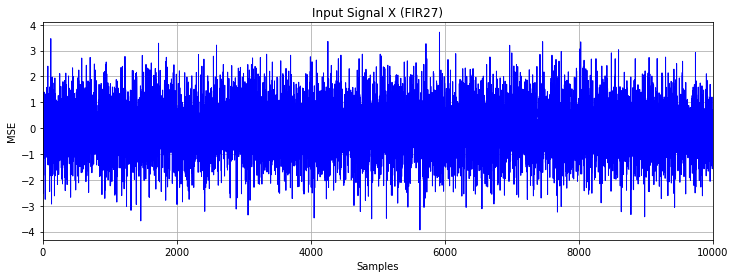

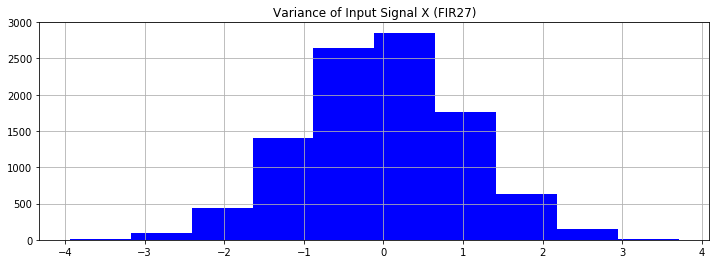

In [27]:
# load FIR data from dictionary
HfirD = importMat['System_FIR27']['D_']
HfirX = importMat['System_FIR27']['X']

# check input signal variance and plot
ts.plot(HfirX,'Input Signal X (FIR27)','lin',10000)
ts.hist(HfirX,'Variance of Input Signal X (FIR27)')
print('Input signal mean: ',np.mean(HfirX))
print('Input signal variance: ',np.var(HfirX))

#### Aufgabe 1: Systemidentifikation eines FIR Systems mit variablem AWGNS
- a) Einfluss der Filtertaps $N$,  Rauschvarianz $\sigma^2$ und Schrittweite $\mu$ auf den LMS Adaptionsalgorithmus

Zunächst werden wie in _Aufgabe 1_ verlangt alle Filtergewichte und Fehlerwerte je Iteration von der LMS Funktion gespeichter und somit dokumentiert. Der mittlere quadratische Fehler (engl. Mean-Squared Error bzw. MSE) wird hierbei im oberen Subplot als Lernkurve pro Iteration in Samples aufgetragen. 
Ein gegen 0 konvergierender Verlauf ist hier optimal, denn so zeigt sich das der Fehler zwischen dem gewünschten Signal und dem Ausgang des Filters geringer wird und das sich somit auch das Filterverhalten durch den Algorithmus verbessert.
Der untere Subplot visualisizert die jeweiligen Filtergewichte für jede Iteration. Eine Konvergenz zu einem fixen Wert für jeden Filtertap ist hier erwünscht und zeigt das das sich der Filter zunehmend auf ein Optimum zubewegt.

**Die Anzahl der Filtertaps $N$** is maßgeblich für die Komplexität des adaptiven Filters. 

**Die Schrittweite $\mu$** beeinflusst wie stark der Fehler die Optimierung für jede Iteration gewichtet. Ein großes $\mu$ erhöht dabei die Geschwindigkeit der Adaption, kann aber auch zu sehr "nervösem" Verhalten der Adaption führen und eine Konvergenz ins Fehlerminimum durch ständiges Über- und Unterschreiten der Optimalgewichtung unmöglich machen.

**Die Rauschvarianz $\sigma^2$** beeinflusst die Standardabweichung des AWGNS (Additive White Gaussian Noise), welches dem in der Simulation übertragenen Signal $d[k]$ durch die Messstrecke aufaddiert wird. Die Varianz beeinflusst hiermit die "Stärke" des Rauschens indem durch große Werte auch große, zufällige Amplitudenwerte möglich sind. Kleine Werte für $\sigma^2$ halten also das Signal-Rausch-Verhältnis groß (SNR groß) und große Werte für $\sigma^2$ erwirken ein geringeres Signal-Rausch-Verhältnis. Große Werte "verrauschen" das Zielsignal also stärker, was in unserer Simulation einer schlechteren Übertragunggstrecke entsprechen würde.
Mit dem hinzufügen des AWGNS können wir die Stabilität des Filters gegenüber Rauschen prüfen und somit ermitteln welche Algorithmen sich für ein solches Problem Übertragungsproblem eignen und wie schlecht die Verbindung dabei werden darf um trotzdem zufriedenstellende Ergebnisse zu erhalten.


* LMS: N = 1, mu = 0.001, w = [0.70320338]
       with AWGNS variance = 0.001


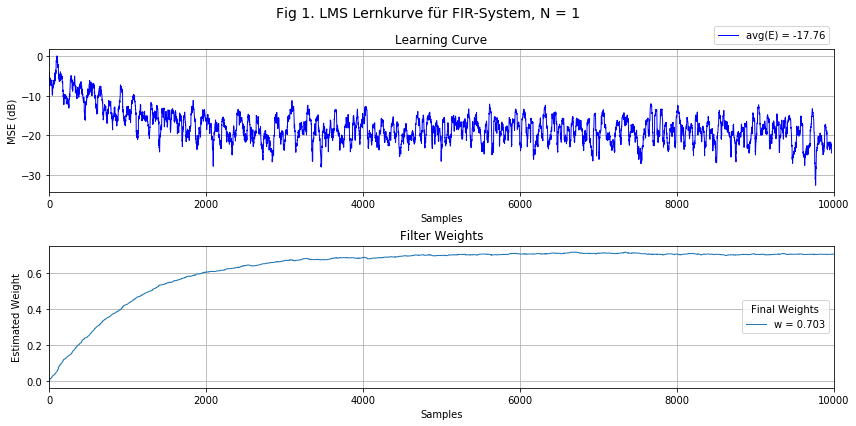

In [28]:
# FIR LMS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 10000
FigNum = 0

# N = 1
N, mu, var = 1, 0.001, 0.001
HfirDn = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 1. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var))

**Fig 1.** Um die Komplexität des FIR-Systems aus der Aufgabe mit $N = 5$ zu erreichen sind, wie im ersten Plot oben zu sehen $N = 1$ Taps nicht hinreichend für eine vollständig rauschfreie Übertragung. Obwohl hier eine optimale Übertragungsstrecke vorliegt ($\sigma_1^2 = 0$) und die Schrittweite sehr gering gewählt wurde verbleibt im Schnitt einen Rauschteppich von etwa $-18 \,dB$. Eine Rauschtoleranz müsste beim Entwurf des Systems vorher definiert werden um eine Eignung des zu prüfenden Systems zu definieren. Ansonsten verbleibt nur eine qualitative Auswertung.

* LMS: N = 2, mu = 0.001, w = [0.70038074 0.10375412]
       with AWGNS variance = 0.01


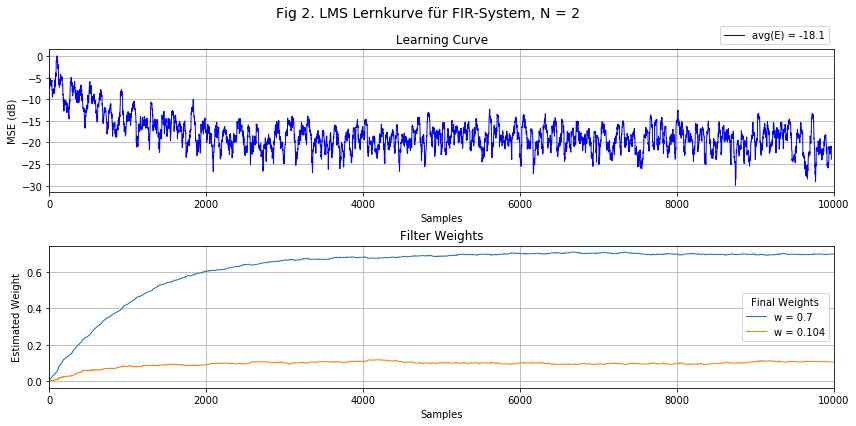

In [29]:
# N = 2
N, mu, var = 2, 0.001, 0.01
HfirDn = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 2. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var))

**Fig 2.** Eine ähnlich gute Rauschunterdrückung mit verbleibenden etwa $-18 \,dB$ erfolgt trotz der zehnfachen Varianz ($\sigma_2^2 = 0.01 = 10 \cdot \sigma_1^2$) bei Verdopplung der Anzahl der Filtertaps auf $N = 2$.

* LMS: N = 5, mu = 0.001, w = [ 0.69131358  0.10427855 -0.02966732  0.18586015 -0.2439442 ]
       with AWGNS variance = 0.1
* LMS: N = 5, mu = 0.1, w = [ 0.7   0.1  -0.03  0.18 -0.24]
       with AWGNS variance = 0


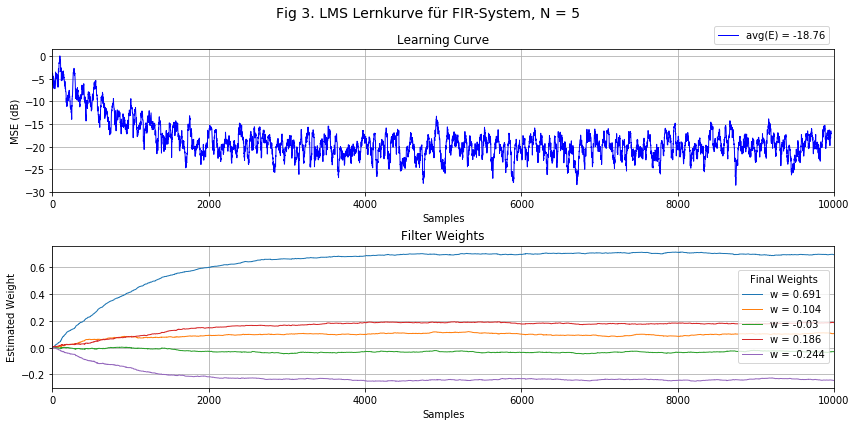

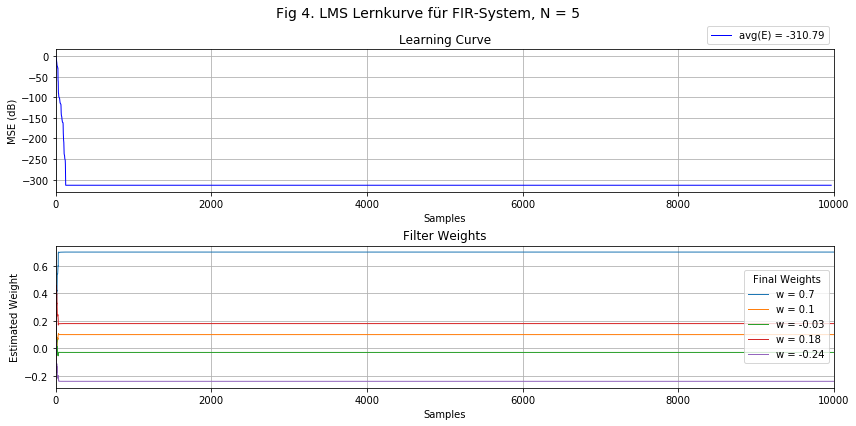

In [30]:
# N = 5
N, mu, var = 5, 0.001, 0.1
HfirDn = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 3. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var))

N, mu, var = 5, 0.1, 0
HfirDn = ts.addNoise(HfirD, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirX, HfirDn, np.zeros(N))
ts.errorPlot(E, W, plotLen, 'Fig 4. LMS Lernkurve für FIR-System, N = '+str(N), style='log')
print('       with AWGNS variance = '+str(var))

**Fig 3.** Mit $N = 5$ erhält man die selbe Rauschunterdrückung von etwa $-18 \,dB$ selbst bei einer weiteren Verzehnfachung der Rauschvarianz.

**Fig 4.** Exemplarisch wird hier eine sehr große Schrittweite von $\mu = 0.2$ *ohne* AWGNS gewählt um zu demonstrieren, dass der LMS Algorithmus unter Optimalbedingungen (kein Rauschen in der Übertragungsstrecke) sehr schnell die exakten, optimale Gewichtung adaptieren kann.

* RLS: N = 5, mu = 0.001, w = [ 0.69377847  0.09858068 -0.03031224  0.17759239 -0.23855695]
       with AWGNS variance = 0.01


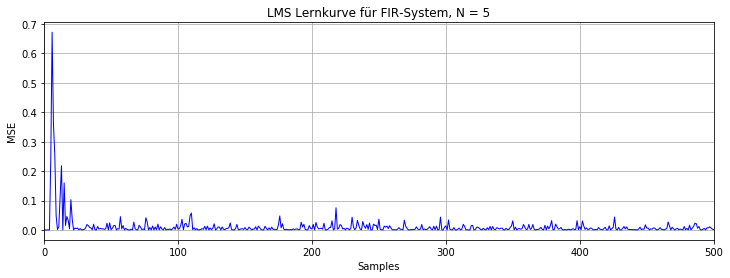

In [18]:
# FIR RLS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 500
plotStyle = 'lin'

# N = 1
N, mu, var = 5, 0.001, 0.01
HfirXn = ts.addNoise(HfirX, var)
E, W, w, Yd = algo.rlsAlg(N, mu, HfirXn, HfirD, np.zeros(N))
ts.plot(E.T ,'LMS Lernkurve für FIR-System, N = '+str(N),plotStyle, plotLen)
print('       with AWGNS variance = '+str(var))

#### Aufgabe 1: Systemidentifikation eines FIR Systems mit variablem AWGNS
Wie in den plots oben zu sehen...

## Aufgabe 2
Für das IIR-Filter: Stelle die gleichen Untersuchungen wie beim FIR-Filter an.

* LMS: N = 1, mu = 0.001, w = [0.70215652]
       with AWGNS variance = 0.001


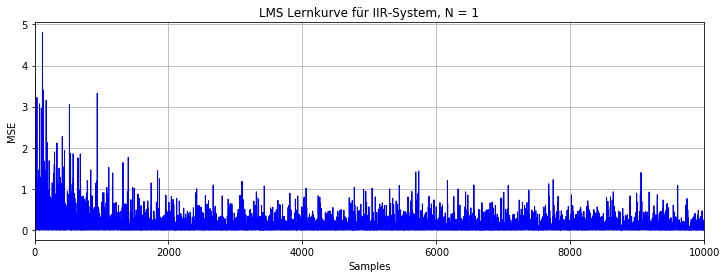

In [19]:
# IIR LMS study
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# N = 1
N, mu, var = 1, 0.001, 0.001
HfirXn = ts.addNoise(HfirX, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXn, HfirD, np.zeros(N))
ts.plot(E.T ,'LMS Lernkurve für IIR-System, N = '+str(N),plotStyle, plotLen)
print('       with AWGNS variance = '+str(var))

#### Aufgabe 2: Systemidentifikation eines IIR Systems mit variablem AWGNS
Wie in den plots oben zu sehen...

## Aufgabe 3
Es soll nun der Einfluss eines plötzlichen Systemwechsels untersucht werden. Dazu werden die Filterkoeffizien- ten des erzeugenden Systems nach 5000 Iterationen geändert. Lade nun die Datei Systemwechsel_FIR.mat und Systemwechsel_IIR.mat. Sie enthalten die gleichen Signale wie schon System_FIR.mat und System_IIR.mat. Zeige wiederum das Lernverhalten für verschiedene Störeinflüsse, Lernalgorithmen und Fitlerordungen. Erläutere auch hieran das Adaptionsverhalten. Welches Verfahren eignet sich unter welchen Bedingungen am besten?

In [20]:
# load FIR data from dictionary
HfirDc = importMat['Systemwechsel_FIR27']['D_']
HfirXc = importMat['Systemwechsel_FIR27']['X']

# check input signal 1 variance and plot
print('Input signal 1 mean: ',np.mean(HfirDc[0,0:5000]))
print('Input signal 1 variance: ',np.var(HfirDc[0,0:5000]))

# check input signal 2
print('Input signal 2 mean: ',np.mean(HfirDc[0,5000:]))
print('Input signal 2 variance: ',np.var(HfirDc[0,5000:]))

Input signal 1 mean:  -0.010424975412711203
Input signal 1 variance:  0.5975436877185286
Input signal 2 mean:  -0.006704814028154175
Input signal 2 variance:  0.33584297731446144


* LMS: N = 5, mu = 0.01, w = [ 0.39113468 -0.00829246  0.29634512 -0.17516657 -0.19202033]
       with AWGNS variance = 0.01


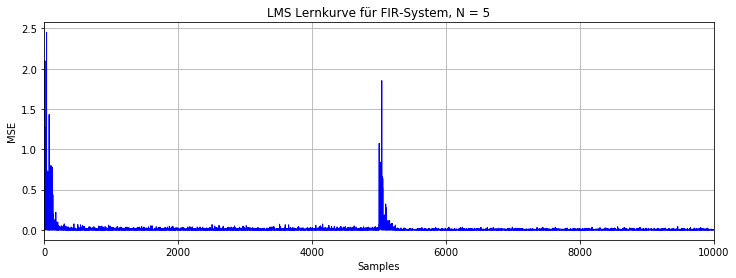

In [21]:
# FIR LMS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# N = 1
N, mu, var = 5, 0.01, 0.01
HfirXcn = ts.addNoise(HfirXc, var)
E, W, w, Yd = algo.lmsAlg(N, mu, HfirXcn, HfirDc, np.zeros(N))
ts.plot(E.T ,'LMS Lernkurve für FIR-System, N = '+str(N),plotStyle, plotLen)
print('       with AWGNS variance = '+str(var))

* RLS: N = 5, mu = 0.01, w = [ 0.49803628  0.04466818  0.12344825  0.00094756 -0.20063424]
       with AWGNS variance = 0.1


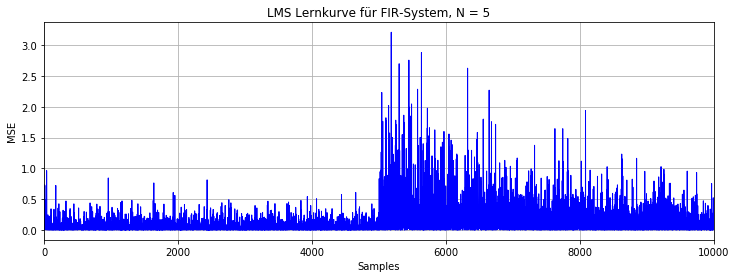

In [25]:
# FIR RLS study: System change
# N  = 1, 2, 5
# mu = free
# var = 0.001, 0.1, 1, 10

# Length of displayed plot
plotLen = 10000
plotStyle = 'lin'

# N = 1
N, mu, var = 5, 0.01, 0.1
HfirXcn = ts.addNoise(HfirXc, var)
E, W, w, Yd = algo.rlsAlg(N, mu, HfirXcn, HfirDc, np.zeros(N))
ts.plot(E.T ,'LMS Lernkurve für FIR-System, N = '+str(N),plotStyle, plotLen)
print('       with AWGNS variance = '+str(var))

## Aufgabe 4
Es soll nun ein Kernel Least Mean Squares (KLMS) Filter entworfen werden, dass eine Zeitreihenschätzung vor- nimmt. Zum Training wird eine Zeitreihe mit 500 Werten in der Datei Training.mat gegeben. Das trainierte Filter soll anschließend mit der Zeitreihe in Test.mat getestet werden. Der Kernel des KLMS darf aus der Fa- milie der Exponentialfunktionen frei gewählt werden (Gauss, Laplace, oä.). Zum Vergleich der Schätzfähigkeit des KLMS sollen sowohl 5 vergangene als auch 10 vergangene Werte zur Schätzung herangezogen werden. Das gleiche Testszenario soll weiterhin mit einem LMS umgesetzt und für einen Vergleich zum KLMs herangezo- gen werden. Dazu sind Fehlerkurven auf den Testdaten zu erstellen sowie Erläuterungen zu den Einflüssen der jeweiligen Parameter der Filter anzugeben.

In [26]:
# load KLMS training and test data from dictionary
x_training = importMat['Training']['x_training']
x_test = importMat['Test']['x_test']